In [1]:
! wget -q https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
! tar -zxf imagewoof2-320.tgz

In [2]:
import os
import copy
import random

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelBinarizer

import torch
from torch import nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

In [3]:
def read_csv_annotation(path, incorrect_labels_percent=0):
    if incorrect_labels_percent not in [0, 1, 5, 25, 50]:
        raise ValueError('incorrect_labels_percent should be in [0, 1, 5, 25, 50]')

    labels_column_name = f'noisy_labels_{incorrect_labels_percent}'
    annotation = pd.read_csv(path)

    annotation = annotation[['path', labels_column_name, 'is_valid']]
    annotation.rename(columns={labels_column_name: 'label'}, inplace=True)

    return annotation

In [4]:
class ImageWoofDataset(Dataset):

    def __init__(self, annotation, root_dir, label_binarizer=None, transform=None):

        self.annotation = annotation
        self.root_dir = root_dir
        self.transform = transform
        self.label_binarizer = label_binarizer

    def __len__(self):
        return len(self.annotation)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.annotation.iloc[index, 0])
        image = Image.open(image_path).convert('RGB')

        label = self.annotation.iloc[index, 1]
        bin_label = self.label_binarizer.transform([label]).squeeze()

        if self.transform:
            image = self.transform(image)
        
        return {
            'X': torch.FloatTensor(np.array(image)),
            'y': torch.FloatTensor(bin_label)
        }

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer,\
                scheduler, num_epochs, verbose=True):
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    metrics_history = {
        'train_accuracy': [],
        'val_accuracy': [],
        'train_loss': [],
        'val_loss': []
    }

    for epoch in tqdm(range(num_epochs), disable = not verbose):

        train_loss = 0.0
        train_corrects = 0.0
        model.train()
        for _, item in enumerate(train_loader):
            optimizer.zero_grad()

            X = item['X'].to(device)
            y = item['y'].to(device)
            
            predictions = model(X)

            loss = criterion(predictions, y)
            loss.backward()

            optimizer.step()

            train_loss += loss.item() * X.size(0)

            pred_labels = torch.argmax(predictions, dim=1)
            true_labels = torch.argmax(y, dim=1)
            train_corrects += torch.sum(pred_labels == true_labels).item()

        scheduler.step()

        val_loss = 0.0
        val_corrects = 0.0
        model.eval()
        for _, item in enumerate(val_loader):
            with torch.no_grad():
                X = item['X'].to(device)
                y = item['y'].to(device)

                predictions = model(X)
                
                loss = criterion(predictions, y)

                val_loss += loss.item() * X.size(0)

                pred_labels = torch.argmax(predictions, dim=1)
                true_labels = torch.argmax(y, dim=1)
                val_corrects += torch.sum(pred_labels == true_labels).item()

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_accuracy = train_corrects / len(train_loader.dataset)
        val_accuracy = val_corrects / len(val_loader.dataset)

        metrics_history['train_loss'].append(train_loss)
        metrics_history['val_loss'].append(val_loss)
        metrics_history['train_accuracy'].append(train_accuracy)
        metrics_history['val_accuracy'].append(val_accuracy)

        if verbose:
            print((f'Epoch {epoch + 1}  |  [train, val] loss: {round(train_loss, 5)}, {round(val_loss, 5)}'
                   f'  |  [train, val] acc: {round(train_accuracy, 3)}, {round(val_accuracy, 3)}'))
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, metrics_history

In [6]:
def plot_metrics(metrics_history):
    nrows = (len(metrics_history) + 1) // 2
    fig, axes = plt.subplots(nrows, 2)

    for i, metric in enumerate(metrics_history):
        axes[i//2][i%2].plot(range(1, len(metrics_history[metric])+1),
                             metrics_history[metric],
                             color='green')
        axes[i//2][i%2].set_xlabel('epoch')
        axes[i//2][i%2].set_ylabel(metric)
    
    fig.set_figwidth(16)
    fig.set_figheight(5*nrows)
    fig.show()

In [7]:
def predict(model, label_binarizer, image, transform=None):
    if transform:
        image = transform(image)
    
    with torch.no_grad():
        image_tensor = torch.FloatTensor(np.array(image)).unsqueeze(0).to(device)
        predictions = model(image_tensor).cpu().numpy()
        pred_classes = label_binarizer.inverse_transform(predictions, threshold=0)

    return pred_classes[0]

---

In [8]:
dataset_annotation = read_csv_annotation('imagewoof2-320/noisy_imagewoof.csv', incorrect_labels_percent=0)
train_annotation = dataset_annotation[dataset_annotation['is_valid'] == False].drop(columns=['is_valid'])
val_annotation = dataset_annotation[dataset_annotation['is_valid'] == True].drop(columns=['is_valid'])

In [9]:
label_binarizer = LabelBinarizer().fit(dataset_annotation['label'])

In [10]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224), scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
train_dataset = ImageWoofDataset(train_annotation, 'imagewoof2-320', 
                                 label_binarizer=label_binarizer, 
                                 transform=train_transform)
val_dataset = ImageWoofDataset(val_annotation, 'imagewoof2-320', 
                               label_binarizer=label_binarizer, 
                               transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device.type)

cuda


In [ ]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [ ]:
model, metrics_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1  |  [train, val] loss: 0.31667, 0.30679  |  [train, val] acc: 0.222, 0.242
Epoch 2  |  [train, val] loss: 0.27951, 0.32793  |  [train, val] acc: 0.306, 0.233
Epoch 3  |  [train, val] loss: 0.26115, 0.26688  |  [train, val] acc: 0.363, 0.35
Epoch 4  |  [train, val] loss: 0.2411, 0.30644  |  [train, val] acc: 0.442, 0.334
Epoch 5  |  [train, val] loss: 0.23159, 0.26316  |  [train, val] acc: 0.466, 0.4
Epoch 6  |  [train, val] loss: 0.22215, 0.25452  |  [train, val] acc: 0.492, 0.432
Epoch 7  |  [train, val] loss: 0.20917, 0.2364  |  [train, val] acc: 0.524, 0.487
Epoch 8  |  [train, val] loss: 0.19684, 0.21835  |  [train, val] acc: 0.564, 0.517
Epoch 9  |  [train, val] loss: 0.1876, 0.308  |  [train, val] acc: 0.59, 0.393
Epoch 10  |  [train, val] loss: 0.17713, 0.27354  |  [train, val] acc: 0.617, 0.436
Epoch 11  |  [train, val] loss: 0.16732, 0.20244  |  [train, val] acc: 0.641, 0.573
Epoch 12  |  [train, val] loss: 0.15949, 0.18716  |  [train, val] acc: 0.658, 0.602
Epoch 13  

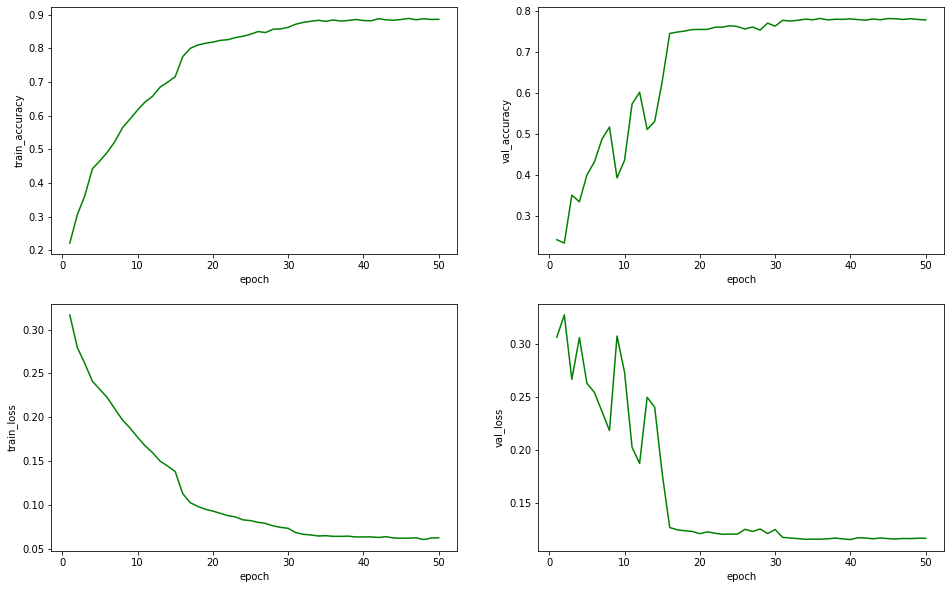

In [ ]:
plot_metrics(metrics_history)

In [ ]:
print('Best accuracy:', max(metrics_history['val_accuracy']))

Best accuracy: 0.782641893611606


---

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

model, metrics_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, verbose=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1  |  [train, val] loss: 0.14672, 0.15782  |  [train, val] acc: 0.721, 0.694
Epoch 2  |  [train, val] loss: 0.10581, 0.10824  |  [train, val] acc: 0.799, 0.791
Epoch 3  |  [train, val] loss: 0.09659, 0.09774  |  [train, val] acc: 0.813, 0.805
Epoch 4  |  [train, val] loss: 0.08361, 0.13057  |  [train, val] acc: 0.843, 0.763
Epoch 5  |  [train, val] loss: 0.08249, 0.11474  |  [train, val] acc: 0.843, 0.787
Epoch 6  |  [train, val] loss: 0.07159, 0.11067  |  [train, val] acc: 0.867, 0.803
Epoch 7  |  [train, val] loss: 0.06624, 0.1367  |  [train, val] acc: 0.874, 0.757
Epoch 8  |  [train, val] loss: 0.07026, 0.10366  |  [train, val] acc: 0.87, 0.801
Epoch 9  |  [train, val] loss: 0.06116, 0.0828  |  [train, val] acc: 0.888, 0.834
Epoch 10  |  [train, val] loss: 0.05657, 0.09656  |  [train, val] acc: 0.892, 0.821
Epoch 11  |  [train, val] loss: 0.05916, 0.106  |  [train, val] acc: 0.893, 0.808
Epoch 12  |  [train, val] loss: 0.05183, 0.08314  |  [train, val] acc: 0.902, 0.854
Epoch 

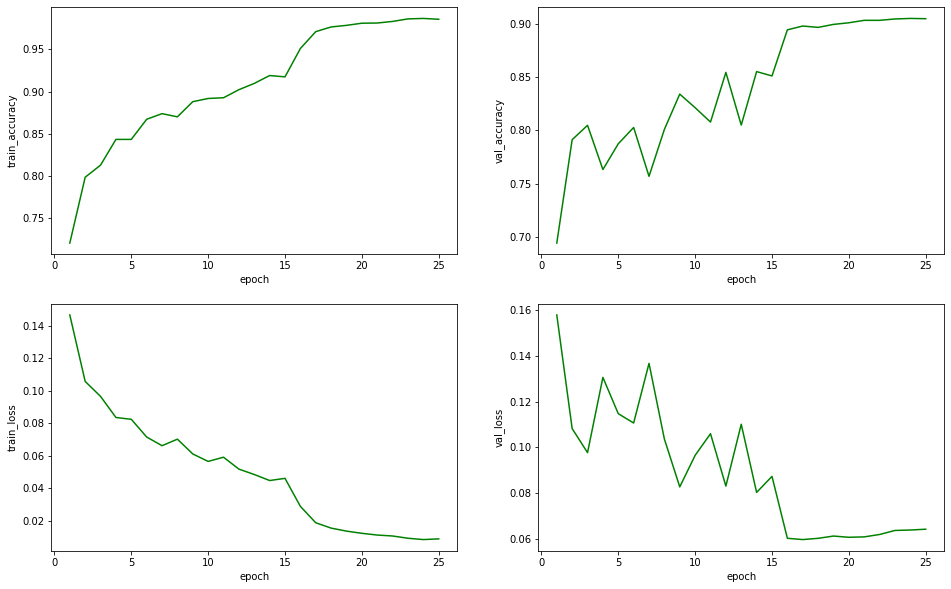

In [ ]:
plot_metrics(metrics_history)

In [ ]:
print('Best accuracy:', max(metrics_history['val_accuracy']))

Best accuracy: 0.9050649020106898


---

In [ ]:
model = models.mobilenet_v2(pretrained=True)
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                  nn.Linear(in_features=model.classifier[1].in_features, out_features=10, bias=True))
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

model, metrics_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, verbose=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1  |  [train, val] loss: 0.10869, 0.08264  |  [train, val] acc: 0.81, 0.844
Epoch 2  |  [train, val] loss: 0.07086, 0.08627  |  [train, val] acc: 0.862, 0.839
Epoch 3  |  [train, val] loss: 0.06321, 0.07453  |  [train, val] acc: 0.883, 0.864
Epoch 4  |  [train, val] loss: 0.05667, 0.07923  |  [train, val] acc: 0.898, 0.855
Epoch 5  |  [train, val] loss: 0.05082, 0.08623  |  [train, val] acc: 0.905, 0.863
Epoch 6  |  [train, val] loss: 0.04866, 0.07904  |  [train, val] acc: 0.912, 0.866
Epoch 7  |  [train, val] loss: 0.0456, 0.09926  |  [train, val] acc: 0.916, 0.834
Epoch 8  |  [train, val] loss: 0.03973, 0.07616  |  [train, val] acc: 0.928, 0.869
Epoch 9  |  [train, val] loss: 0.04211, 0.08354  |  [train, val] acc: 0.924, 0.865
Epoch 10  |  [train, val] loss: 0.03834, 0.07404  |  [train, val] acc: 0.929, 0.874
Epoch 11  |  [train, val] loss: 0.03282, 0.09243  |  [train, val] acc: 0.942, 0.844
Epoch 12  |  [train, val] loss: 0.03489, 0.08235  |  [train, val] acc: 0.937, 0.868
Epo

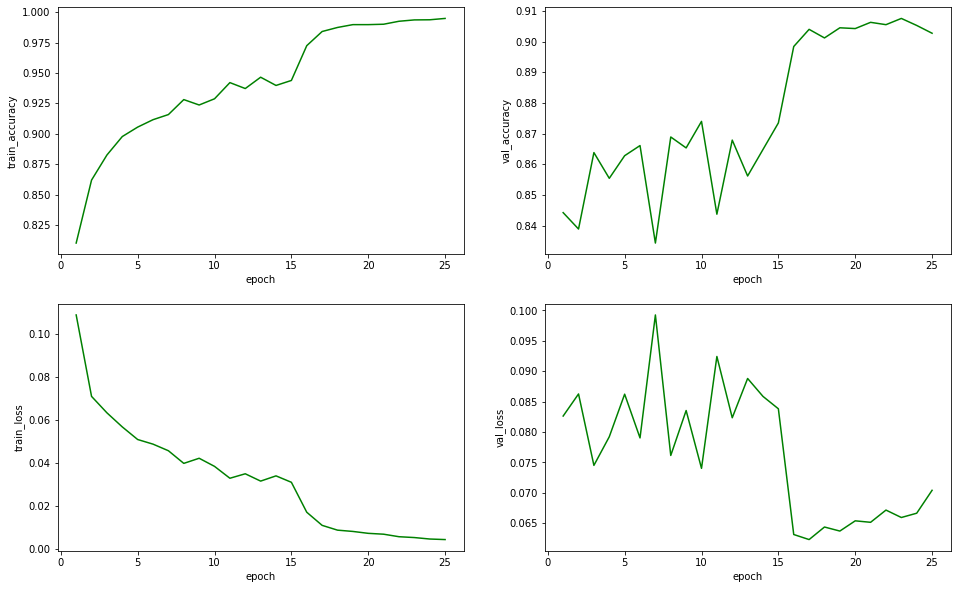

In [ ]:
plot_metrics(metrics_history)

In [ ]:
print('Best accuracy:', max(metrics_history['val_accuracy']))

Best accuracy: 0.9076100789004836


---

In [ ]:
class_name = {
  'n02086240': 'Shih-Tzu',
  'n02087394': 'Rhodesian ridgeback',
  'n02088364': 'Beagle',
  'n02089973': 'English foxhound',
  'n02093754': 'Australian terrier',
  'n02096294': 'Border terrier',
  'n02099601': 'Golden retriever',
  'n02105641': 'Old English sheepdog',
  'n02111889': 'Samoyed',
  'n02115641': 'Dingo'
}

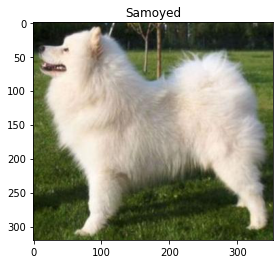

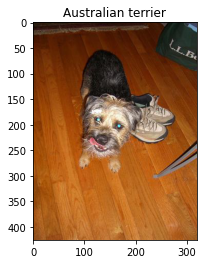

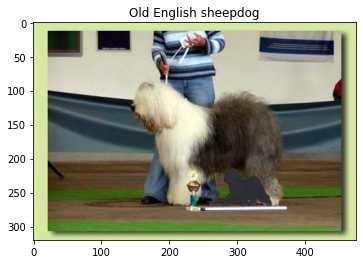

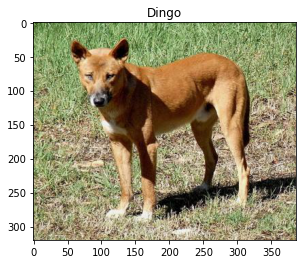

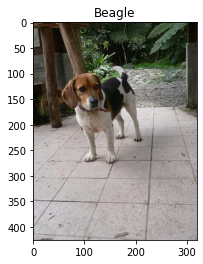

In [ ]:
n_examples = 5

for _ in range(n_examples):
    index = random.randint(0, len(val_annotation) - 1)
    img_path = os.path.join('imagewoof2-320', val_annotation.iloc[index, 0])
    img = Image.open(img_path).convert('RGB')

    pred = predict(model, label_binarizer, img, transform=val_transform)
    name = class_name[pred]
     
    plt.imshow(img)
    plt.title(name)
    plt.show()

In [ ]:
PATH = './mobilenet_2.pth'

In [ ]:
torch.save(model, PATH)

In [ ]:
the_model = torch.load(PATH)

In [ ]:
the_model.eval()

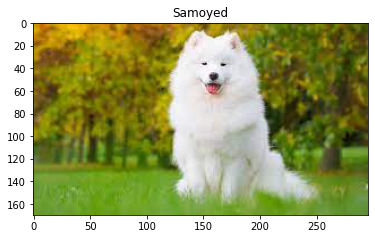

In [ ]:
# img_path = os.path('/content/beag.jpeg')
img = Image.open('/content/sam.jpeg').convert('RGB')

pred = predict(the_model, label_binarizer, img, transform=val_transform)
name = class_name[pred]
  
plt.imshow(img)
plt.title(name)
plt.show()

In [ ]:
def predict(img_path, model):
    # image_path = '/content/beag.jpeg'
    input_image = Image.open(img_path)
    preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    input_tensor = preprocess(input_image)

    # create a mini-batch as expected by the model
    input_batch = input_tensor.unsqueeze(0) 

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        the_model.to('cuda')

    with torch.no_grad():
        output = the_model(input_batch)
        image_tensor = torch.FloatTensor(np.array(input_tensor)).unsqueeze(0).to(device)
        predictions = the_model(image_tensor).cpu().numpy()
        pred_classes = label_binarizer.inverse_transform(predictions, threshold=0)

    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    output = torch.nn.functional.softmax(output[0], dim=0)
    confidence, index = torch.max(output, 0)
    # top_p= torch.topk(output, 3)
    top_p, ind = output.topk(3)  
    top_p = top_p.tolist()
    ind = ind.tolist()
    return top_p, ind
print(top_p[0], ind[0])
print(class_anme[pred[0]])

94.26193
0.9426193237304688 3
English foxhound


In [ ]:
classes_name = ['Shih-Tzu','Rhodesian ridgeback','Beagle','English foxhound',\
                'Australian terrier','Border terrier',\
                'Golden retriever','Old English sheepdog','Samoyed','Dingo']